In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
pwd

'C:\\Users\\635718\\Desktop\\DataScience\\HackerEarth\\Brainwave'

In [40]:
train = pd.read_csv('./AnnualReturns/train.csv')
test = pd.read_csv('./AnnualReturns/test.csv')

In [42]:
id_test = test['portfolio_id'].values

In [4]:
train_objs_num = len(train)
train = pd.concat(objs=[train, test], axis=0)

In [5]:
train.shape

(14167, 18)

In [41]:
train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,20040720,NaN,20040812,B,NaN,NaN,0.02496
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,20040723,NaN,20040812,C,NaN,NaN,0.05496
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,20040723,NaN,20040817,A,NaN,NaN,0.02496
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,1.645088e+08,20040723,NaN,20040713,A,NaN,NaN,0.02496
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,1.405402e+08,20040723,NaN,20040713,B,NaN,NaN,0.02496


In [ ]:
train.info()

In [ ]:
train['return'].describe()

In [ ]:
sns.distplot(train['return']*100, kde=False, bins=100)

In [ ]:
#sns.jointplot(x='sell_date',y='return',data=train)

In [ ]:
train['country_code'].value_counts()

In [ ]:
#sns.jointplot(x='office_id',y='return',data=train)

In [ ]:
train.columns

In [ ]:
#Missing Data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

In [ ]:
#train['libor_rate'].value_counts()

In [6]:
#add missing data
train['hedge_value'].fillna(False, inplace=True)
train['indicator_code'].fillna(False, inplace=True)
train['status'].fillna(False, inplace=True)
train['libor_rate'].fillna(train['libor_rate'].mean(), inplace=True)
train['sold'].fillna(0, inplace=True)
train['bought'].fillna(0, inplace=True)

In [7]:
train['start_date'] = pd.to_datetime(train['start_date'],format='%Y%m%d')
train['creation_date'] = pd.to_datetime(train['creation_date'],format='%Y%m%d')
train['sell_date'] = pd.to_datetime(train['sell_date'],format='%Y%m%d')

In [39]:
train.head()

,country_code,currency,euribor_rate,hedge_value,indicator_code,libor_rate,office_id,pf_category,portfolio_id,return,status,type,days_invested,amount_earned
0,2,4,0.02074,False,False,2.332216,1,1,1,0.02496,False,1,23,190336.749636
1,1,2,0.02074,False,False,5.269617,0,0,2,0.05496,False,2,34,662563.265958
2,2,4,0.02074,False,False,2.332216,0,0,4,0.02496,False,0,25,94467.039667
3,2,4,0.02074,False,False,2.332216,0,0,5,0.02496,False,0,34,304158.569044
4,2,4,0.02074,False,False,2.332216,1,1,6,0.02496,False,1,34,259843.134474


In [ ]:
#((train['sell_date'] - train['start_date']) / np.timedelta64(1, 'D')).astype(int)

In [8]:
#calculate days of investment
train['days_invested'] = ((train['sell_date'] - train['start_date']) / np.timedelta64(1, 'D')).astype(int)

In [9]:
#calculate amount earned on investment
train['amount_earned'] = (train['sold'] - train['bought'])

In [ ]:
train.columns

In [10]:
train.drop(['desk_id','start_date','sold','bought','creation_date','sell_date'],axis=1,inplace=True)

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
sns.jointplot(x='amount_earned',y='return',data=train)

In [11]:
train_features = [x for x in train.columns if x not in ['portfolio_id','target']]

In [12]:
#Encode the data
for column in train_features:
    if train[column].dtype == type(object):
        le = LabelEncoder()
        le.fit(train[column])
        train[column] = le.transform(train[column])

In [13]:
cat_cols = ['office_id', 'pf_category', 'country_code', 'currency', 'type']

In [14]:
dataset_preprocessed = pd.get_dummies(train, columns = cat_cols)

In [15]:
train_features = [x for x in dataset_preprocessed.columns if x not in ['portfolio_id','return']]

In [ ]:
dataset_preprocessed.head()

In [16]:
train_preprocessed = dataset_preprocessed[:train_objs_num]
test_preprocessed = dataset_preprocessed[train_objs_num:]

In [17]:
X = train_preprocessed[train_features].values
y = train_preprocessed.loc[:,'return'].values
T = test_preprocessed[train_features].values

In [ ]:
y

In [ ]:
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()
normalizer.fit_transform(X)

In [29]:
stacker = RandomForestRegressor(n_estimators=150,random_state=0,oob_score=True)
stacker.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [30]:
y_pred = stacker.predict(T)

In [35]:
stacker.score

<bound method RegressorMixin.score of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)>

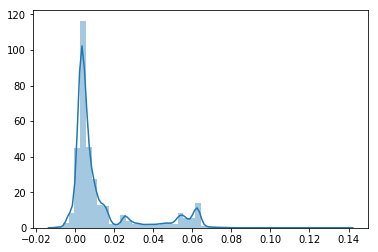

In [38]:
sns.distplot(y_pred)

In [ ]:
stacker = RandomForestRegressor(n_estimators=150,random_state=0)
results = cross_val_score(stacker, X, y, cv=5, scoring='r2')
print(results)
print("Stacker score: {} ".format(results.mean()))

In [43]:
sub = pd.DataFrame()
sub['portfolio_id'] = id_test
sub['return'] = y_pred
sub.to_csv('sub_rf.csv', index=False)

print('completed')

completed
